In [1]:
import numpy as np
import pandas as pd
from copy import copy
import sys
sys.path.append('/home/ndsviriden/MinMax94/src/utils') 
from constants import data_directory, MmxColumns
from interpolation import interpolate_mmx, create_patterns
from converters import convert_raw_to_mmx
from preprocessing import get_clean_data
from generate_anomalies import generate_single_anomaly, generate_short_term_anomaly, generate_long_term_anomaly
from loaders import load_mm94_stations, select_mm94_features
from geographical import find_nearest_wmo_station, add_solar_angles, add_coordinates, add_road_id
from sklearn.ensemble import IsolationForest
from score import get_labels
from score import calc_precision, calc_recall, calc_f1_score
import matplotlib.pyplot as plt
import gc
from tqdm import tqdm_notebook
from functools import reduce

## Loading data

In [2]:
%%time
test_station_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 
                   511, 516, 1838, 1896]


train_station_id = [113, 115, 116, 118, 126, 150, 152, 200, 223, 228, 
                    239, 305, 308, 309, 401, 411, 432, 435, 454, 456, 
                    593, 628, 1831, 1899, 1911, 1921, 4007, 20323, 20717, 20743, 
                    20754, 20755, 20761, 20916, 20921]

generate_station_id = [615, 618, 620, 624, 626, 627, 635, 702, 
                       704, 862, 874, 888, 1808, 1813, 1826]

raw = load_mm94_stations(train_station_id + test_station_id + generate_station_id)
raw = select_mm94_features(raw, ['t_air', 't_road', 't_underroad', 'pressure', 'dampness'])

mmx_rwis = convert_raw_to_mmx(raw)
mmx_rwis_interpolated = interpolate_mmx(mmx_rwis)
data = create_patterns(mmx_rwis_interpolated)

data['data_solar_azimuth'], data['data_solar_altitude'] = add_solar_angles(data)
data['data_latitude'], data['data_longitude'] = add_coordinates(data)
data['data_road'] = add_road_id(data)
data = data.dropna(subset=('data_t_road', ))

del data[MmxColumns.ID_AIR_TEMPERATURE], data[MmxColumns.ID_UNDERGROUND_TEMPERATURE], \
    data[MmxColumns.ID_PRESSURE], data[MmxColumns.ID_HUMIDITY]

train = data[data['station_id'].isin(train_station_id)]
train = train.reset_index(drop=True)
train_clean = get_clean_data(train)

test = data[data['station_id'].isin(test_station_id)]
test = test.reset_index(drop=True)
test['label_true'] = get_labels(test, labels_type='true')

generated = data[data['station_id'].isin(generate_station_id)]
generated = generated.reset_index(drop=True)
generated_clean = get_clean_data(generated)

del data, raw, mmx_rwis, mmx_rwis_interpolated
gc.collect()

/home/ndsviriden/MinMax94/src/utils/geographical.py:65: RuntimeWarning: invalid value encountered in arccos
  solar_azimuth = np.arccos(cos_az) * np.sign(h_rad)


CPU times: user 2min 1s, sys: 14 s, total: 2min 15s
Wall time: 2min 15s


## Generated anomalies

In [3]:
np.random.seed(42)
to_generate = copy(generated_clean)
to_generate['label_true'] = False
col = MmxColumns.ROAD_TEMPERATURE

#---------------------------------------------------------------------------------
number_of_anomalies = 30 * len(generate_station_id)
index_list = np.random.choice(to_generate.index, number_of_anomalies, replace=False)

for index in index_list:
    perturbated_series = generate_single_anomaly(to_generate, index)
    to_generate.loc[index, col] += perturbated_series
    to_generate.loc[index, 'label_true'] = True
    
#---------------------------------------------------------------------------------
number_of_anomalies = 20 * len(generate_station_id)
index_list = np.random.choice(to_generate.index, number_of_anomalies, replace=False)

for index in index_list:
    perturbated_series = generate_short_term_anomaly(to_generate, index)
    series_duration = len(perturbated_series)
    to_generate.loc[index: (index + series_duration - 1), col] += perturbated_series
    to_generate.loc[index: (index + series_duration - 1), 'label_true'] = True

#---------------------------------------------------------------------------------
number_of_anomalies = 3 * len(generate_station_id)
index_list = np.random.choice(to_generate.index, number_of_anomalies, replace=False)

for index in index_list:
    perturbated_series = generate_long_term_anomaly(to_generate, index)
    series_duration = len(perturbated_series)
    to_generate.loc[index: (index + series_duration - 1), col] += perturbated_series
    to_generate.loc[index: (index + series_duration - 1), 'label_true'] = True

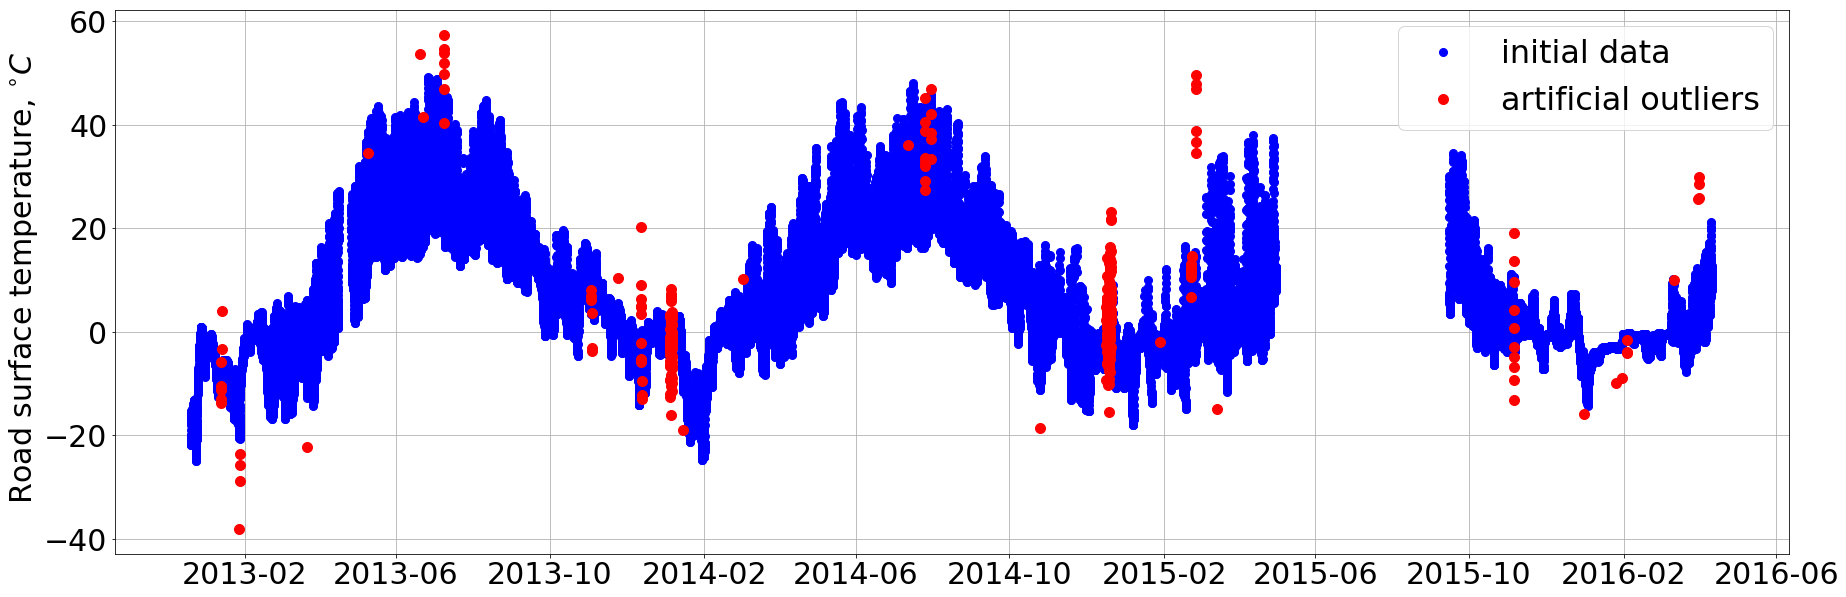

In [4]:
start = pd.Timestamp(2012, 12, 20)
end = pd.Timestamp(2017, 1, 27)

to_plot = to_generate[to_generate['station_id']==615]
to_plot = to_plot[(to_plot['date_time_utc']<=end) & (to_plot['date_time_utc']>=start)]
to_plot = to_plot.set_index('date_time_utc')


plt.figure(figsize=(30, 10))

for elem in [False, True]:
    cond = to_plot['label_true'] == elem
    if elem:
        plt.plot_date(to_plot[cond].index, to_plot[cond]['data_t_road'], 'r',
                      linestyle='none', marker='o', markersize=10, label='artificial outliers')
    else:
        plt.plot_date(to_plot[cond].index, to_plot[cond]['data_t_road'], 'b',
                      linestyle='none', marker='o', markersize=8, label='initial data')

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' Road surface temperature, $^{\circ}C$', fontsize=30)

plt.tick_params(labelsize=30)
plt.show()

## XGBoost

In [5]:
%%time

import pickle
import numpy as np
import xgboost as xgb
from preprocessing import create_feature_df
from sklearn.metrics import mean_absolute_error

point = pd.Timestamp(2015, 6, 1)
clf = pickle.load(open('/mnt/HARD/Diplom/MinMax/models/model_centered/xgboost.pickle', 'rb'))

time = 0.5
variables = ['data_t_road']

df_xgb_real = create_feature_df(test, winter_period=False, time=time,
                           variables=variables)
df_xgb_gen = create_feature_df(to_generate, winter_period=False, time=time,
                           variables=variables)

features = [col for col in df_xgb_real if col.startswith('data_')]
target = [col for col in df_xgb_real if col.startswith('target_')][0]

X_test = np.array(df_xgb_real[features].values)
y_test = np.array(df_xgb_real[target].values.reshape(-1, 1))
dtest = xgb.DMatrix(X_test, y_test)

X_gen = np.array(df_xgb_gen[features].values)
y_gen = np.array(df_xgb_gen[target].values.reshape(-1, 1))
dgen = xgb.DMatrix(X_gen, y_gen)

df_xgb_real['decision_function'] = np.abs(dtest.get_label() - clf.predict(dtest).ravel())
df_xgb_gen['decision_function'] = np.abs(dgen.get_label() - clf.predict(dgen).ravel())

CPU times: user 24.7 s, sys: 3.85 ms, total: 24.7 s
Wall time: 8.27 s


### Label predict. Find optimal

In [6]:
window = pd.Timedelta('4h')
real_station_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]
results = []

df_real = copy(df_xgb_real[['date_time_utc', 'station_id', 'id_t_road', 
                           'target_t_road', 'decision_function', 'label_true']])

df_gen = copy(df_xgb_gen[['date_time_utc', 'station_id', 'id_t_road', 
                         'target_t_road', 'decision_function', 'label_true']])


for thresh in np.arange(4, 12, 0.2):
    
    # Real data
    df_real['label_predict'] = df_real['decision_function'] > thresh
    
    recall_real = calc_recall(df_real, real_station_id, window)
    precision_real = calc_precision(df_real, real_station_id, window)
    f1_real = calc_f1_score(precision_real, recall_real)
    
    # Generated data
    df_gen['label_predict'] = df_gen['decision_function'] > thresh
    
    recall_gen = calc_recall(df_gen, generate_station_id, window)
    precision_gen = calc_precision(df_gen, generate_station_id, window)
    f1_gen = calc_f1_score(precision_gen, recall_gen)
    
    # Save results
    results.append({'threshold': thresh, 
                    'recall_real': recall_real, 
                    'precision_real': precision_real, 
                    'f1_real': f1_real,
                    'recall_gen': recall_gen, 
                    'precision_gen': precision_gen, 
                    'f1_gen': f1_gen})
    
    # Print results
    print('threshold: {0:.2f} \t f1_gen: {1:.3f} \t f1_real: {2:.3f}'.format(thresh, f1_gen, f1_real))
    
results_df = pd.DataFrame(results)
results_df.to_csv('/mnt/HARD/Diplom/MinMax/threshold/xgboost.csv', index=False)

threshold: 4.00 	 f1_gen: 0.913 	 f1_real: 0.433
threshold: 4.20 	 f1_gen: 0.921 	 f1_real: 0.457
threshold: 4.40 	 f1_gen: 0.927 	 f1_real: 0.477
threshold: 4.60 	 f1_gen: 0.933 	 f1_real: 0.496
threshold: 4.80 	 f1_gen: 0.936 	 f1_real: 0.519
threshold: 5.00 	 f1_gen: 0.942 	 f1_real: 0.543
threshold: 5.20 	 f1_gen: 0.945 	 f1_real: 0.563
threshold: 5.40 	 f1_gen: 0.948 	 f1_real: 0.575
threshold: 5.60 	 f1_gen: 0.951 	 f1_real: 0.590
threshold: 5.80 	 f1_gen: 0.951 	 f1_real: 0.609
threshold: 6.00 	 f1_gen: 0.953 	 f1_real: 0.620
threshold: 6.20 	 f1_gen: 0.954 	 f1_real: 0.630
threshold: 6.40 	 f1_gen: 0.956 	 f1_real: 0.643
threshold: 6.60 	 f1_gen: 0.956 	 f1_real: 0.638
threshold: 6.80 	 f1_gen: 0.956 	 f1_real: 0.639
threshold: 7.00 	 f1_gen: 0.957 	 f1_real: 0.651
threshold: 7.20 	 f1_gen: 0.957 	 f1_real: 0.660
threshold: 7.40 	 f1_gen: 0.958 	 f1_real: 0.671
threshold: 7.60 	 f1_gen: 0.958 	 f1_real: 0.648
threshold: 7.80 	 f1_gen: 0.958 	 f1_real: 0.647
threshold: 8.00 	 f1

In [7]:
real_max_f1 = results_df['f1_real'].max()
real_max_point = results_df['threshold'][results_df['f1_real'] == real_max_f1].iloc[0]
real_recall = results_df['recall_real'][results_df['f1_real'] == real_max_f1].iloc[0]
real_precision = results_df['precision_real'][results_df['f1_real'] == real_max_f1].iloc[0]

gen_max_f1 = results_df['f1_gen'].max()
gen_max_point = results_df['threshold'][results_df['f1_gen'] == gen_max_f1].iloc[0]

art_max_point = gen_max_point
art_max_f1 = results_df[results_df['threshold'] == art_max_point]['f1_real'].iloc[0]
art_recall = results_df[results_df['threshold'] == art_max_point]['recall_real'].iloc[0]
art_precision = results_df[results_df['threshold'] == art_max_point]['precision_real'].iloc[0]

print('Real: \t thresh: {0:.2f} \t F1: {1:.3f} \t R: {2:.3f} \t P: {3:.3f}'.
      format(real_max_point, real_max_f1, real_recall, real_precision))

print('Optm: \t thresh: {0:.2f} \t F1: {1:.3f} \t R: {2:.3f} \t P: {3:.3f}'.
      format(art_max_point, art_max_f1, art_recall, art_precision))

df_xgb_real['label_predict'] = df_xgb_real['decision_function'] > art_max_point
df_xgb_gen['label_predict'] = df_xgb_gen['decision_function'] > art_max_point

Real: 	 thresh: 7.40 	 F1: 0.671 	 R: 0.674 	 P: 0.667
Optm: 	 thresh: 7.80 	 F1: 0.647 	 R: 0.640 	 P: 0.655


## XGboost_Noisy

In [8]:
%%time
point = pd.Timestamp(2015, 6, 1)
clf = pickle.load(open('/mnt/HARD/Diplom/MinMax/models/model_centered/xgboost_noisy.pickle', 'rb'))

time = 0.5
variables = ['data_t_road']

df_xgb_n_real = create_feature_df(test, winter_period=False, time=time,
                           variables=variables)
df_xgb_n_gen = create_feature_df(to_generate, winter_period=False, time=time,
                           variables=variables)

features = [col for col in df_xgb_n_real if col.startswith('data_')]
target = [col for col in df_xgb_n_real if col.startswith('target_')][0]

X_test = np.array(df_xgb_n_real[features].values)
y_test = np.array(df_xgb_n_real[target].values.reshape(-1, 1))
dtest = xgb.DMatrix(X_test, y_test)

X_gen = np.array(df_xgb_n_gen[features].values)
y_gen = np.array(df_xgb_n_gen[target].values.reshape(-1, 1))
dgen = xgb.DMatrix(X_gen, y_gen)

df_xgb_n_real['decision_function'] = np.abs(dtest.get_label() - clf.predict(dtest).ravel())
df_xgb_n_gen['decision_function'] = np.abs(dgen.get_label() - clf.predict(dgen).ravel())

CPU times: user 25 s, sys: 276 ms, total: 25.3 s
Wall time: 8.68 s


### Label predict. Find optimal for xgb_noisy.

In [9]:
window = pd.Timedelta('4h')
real_station_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]
results = []

df_real = copy(df_xgb_n_real[['date_time_utc', 'station_id', 'id_t_road', 
                           'target_t_road', 'decision_function', 'label_true']])

df_gen = copy(df_xgb_n_gen[['date_time_utc', 'station_id', 'id_t_road', 
                         'target_t_road', 'decision_function', 'label_true']])


for thresh in np.arange(4, 12, 0.2):
    
    # Real data
    df_real['label_predict'] = df_real['decision_function'] > thresh
    
    recall_real = calc_recall(df_real, real_station_id, window)
    precision_real = calc_precision(df_real, real_station_id, window)
    f1_real = calc_f1_score(precision_real, recall_real)
    
    # Generated data
    df_gen['label_predict'] = df_gen['decision_function'] > thresh
    
    recall_gen = calc_recall(df_gen, generate_station_id, window)
    precision_gen = calc_precision(df_gen, generate_station_id, window)
    f1_gen = calc_f1_score(precision_gen, recall_gen)
    
    # Save results
    results.append({'threshold': thresh, 
                    'recall_real': recall_real, 
                    'precision_real': precision_real, 
                    'f1_real': f1_real,
                    'recall_gen': recall_gen, 
                    'precision_gen': precision_gen, 
                    'f1_gen': f1_gen})
    
    # Print results
    print('threshold: {0:.2f} \t f1_gen: {1:.3f} \t f1_real: {2:.3f}'.format(thresh, f1_gen, f1_real))
    
results_df = pd.DataFrame(results)
results_df.to_csv('/mnt/HARD/Diplom/MinMax/threshold/xgboost_noisy.csv', index=False)

threshold: 4.00 	 f1_gen: 0.930 	 f1_real: 0.431
threshold: 4.20 	 f1_gen: 0.937 	 f1_real: 0.466
threshold: 4.40 	 f1_gen: 0.944 	 f1_real: 0.498
threshold: 4.60 	 f1_gen: 0.949 	 f1_real: 0.527
threshold: 4.80 	 f1_gen: 0.952 	 f1_real: 0.558
threshold: 5.00 	 f1_gen: 0.955 	 f1_real: 0.572
threshold: 5.20 	 f1_gen: 0.958 	 f1_real: 0.593
threshold: 5.40 	 f1_gen: 0.961 	 f1_real: 0.596
threshold: 5.60 	 f1_gen: 0.964 	 f1_real: 0.608
threshold: 5.80 	 f1_gen: 0.964 	 f1_real: 0.613
threshold: 6.00 	 f1_gen: 0.965 	 f1_real: 0.622
threshold: 6.20 	 f1_gen: 0.967 	 f1_real: 0.648
threshold: 6.40 	 f1_gen: 0.967 	 f1_real: 0.674
threshold: 6.60 	 f1_gen: 0.967 	 f1_real: 0.682
threshold: 6.80 	 f1_gen: 0.967 	 f1_real: 0.676
threshold: 7.00 	 f1_gen: 0.968 	 f1_real: 0.686
threshold: 7.20 	 f1_gen: 0.968 	 f1_real: 0.682
threshold: 7.40 	 f1_gen: 0.969 	 f1_real: 0.686
threshold: 7.60 	 f1_gen: 0.970 	 f1_real: 0.684
threshold: 7.80 	 f1_gen: 0.969 	 f1_real: 0.690
threshold: 8.00 	 f1

In [10]:
real_max_f1 = results_df['f1_real'].max()
real_max_point = results_df['threshold'][results_df['f1_real'] == real_max_f1].iloc[0]
real_recall = results_df['recall_real'][results_df['f1_real'] == real_max_f1].iloc[0]
real_precision = results_df['precision_real'][results_df['f1_real'] == real_max_f1].iloc[0]

gen_max_f1 = results_df['f1_gen'].max()
gen_max_point = results_df['threshold'][results_df['f1_gen'] == gen_max_f1].iloc[0]

art_max_point = gen_max_point
art_max_f1 = results_df[results_df['threshold'] == art_max_point]['f1_real'].iloc[0]
art_recall = results_df[results_df['threshold'] == art_max_point]['recall_real'].iloc[0]
art_precision = results_df[results_df['threshold'] == art_max_point]['precision_real'].iloc[0]

print('Real: \t thresh: {0:.2f} \t F1: {1:.3f} \t R: {2:.3f} \t P: {3:.3f}'.
      format(real_max_point, real_max_f1, real_recall, real_precision))

print('Optm: \t thresh: {0:.2f} \t F1: {1:.3f} \t R: {2:.3f} \t P: {3:.3f}'.
      format(art_max_point, art_max_f1, art_recall, art_precision))

df_xgb_n_real['label_predict'] = df_xgb_n_real['decision_function'] > art_max_point
df_xgb_n_gen['label_predict'] = df_xgb_n_gen['decision_function'] > art_max_point

Real: 	 thresh: 8.00 	 F1: 0.698 	 R: 0.636 	 P: 0.775
Optm: 	 thresh: 7.60 	 F1: 0.684 	 R: 0.637 	 P: 0.738


## XGBoost_Air

In [11]:
%%time
point = pd.Timestamp(2015, 6, 1)
clf = pickle.load(open('/mnt/HARD/Diplom/MinMax/models/model_centered/xgboost_air.pickle', 'rb'))

time = 0.5
variables = ['data_t_air', 'data_t_road']

df_xgb_air_real = create_feature_df(test, winter_period=False, time=time,
                           variables=variables)
df_xgb_air_gen = create_feature_df(to_generate, winter_period=False, time=time,
                           variables=variables)

features = [col for col in df_xgb_air_real if col.startswith('data_')]
features = [col for col in features if ('data_t_road' not in col)]
target = [col for col in df_xgb_air_real if col.startswith('target_')][0]

X_test = np.array(df_xgb_air_real[features].values)
y_test = np.array(df_xgb_air_real[target].values.reshape(-1, 1))
dtest = xgb.DMatrix(X_test, y_test)

X_gen = np.array(df_xgb_air_gen[features].values)
y_gen = np.array(df_xgb_air_gen[target].values.reshape(-1, 1))
dgen = xgb.DMatrix(X_gen, y_gen)

df_xgb_air_real['decision_function'] = np.abs(dtest.get_label() - clf.predict(dtest).ravel())
df_xgb_air_gen['decision_function'] = np.abs(dgen.get_label() - clf.predict(dgen).ravel())

CPU times: user 26.3 s, sys: 868 ms, total: 27.1 s
Wall time: 10.2 s


### Label predict. Find optimal for xgb_air.

In [12]:
window = pd.Timedelta('4h')
real_station_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]
results = []

df_real = copy(df_xgb_air_real[['date_time_utc', 'station_id', 'id_t_road', 
                           'target_t_road', 'decision_function', 'label_true']])

df_gen = copy(df_xgb_air_gen[['date_time_utc', 'station_id', 'id_t_road', 
                         'target_t_road', 'decision_function', 'label_true']])


for thresh in np.arange(9, 25, 0.5):
    
    # Real data
    df_real['label_predict'] = df_real['decision_function'] > thresh
    
    recall_real = calc_recall(df_real, real_station_id, window)
    precision_real = calc_precision(df_real, real_station_id, window)
    f1_real = calc_f1_score(precision_real, recall_real)
    
    # Generated data
    df_gen['label_predict'] = df_gen['decision_function'] > thresh
    
    recall_gen = calc_recall(df_gen, generate_station_id, window)
    precision_gen = calc_precision(df_gen, generate_station_id, window)
    f1_gen = calc_f1_score(precision_gen, recall_gen)
    
    # Save results
    results.append({'threshold': thresh, 
                    'recall_real': recall_real, 
                    'precision_real': precision_real, 
                    'f1_real': f1_real,
                    'recall_gen': recall_gen, 
                    'precision_gen': precision_gen, 
                    'f1_gen': f1_gen})
    
    # Print results
    print('threshold: {0:.2f} \t f1_gen: {1:.3f} \t f1_real: {2:.3f}'.format(thresh, f1_gen, f1_real))
    
results_df = pd.DataFrame(results)
results_df.to_csv('/mnt/HARD/Diplom/MinMax/threshold/xgboost_air.csv', index=False)

threshold: 9.00 	 f1_gen: 0.640 	 f1_real: 0.255
threshold: 9.50 	 f1_gen: 0.672 	 f1_real: 0.308
threshold: 10.00 	 f1_gen: 0.695 	 f1_real: 0.361
threshold: 10.50 	 f1_gen: 0.713 	 f1_real: 0.419
threshold: 11.00 	 f1_gen: 0.730 	 f1_real: 0.479
threshold: 11.50 	 f1_gen: 0.747 	 f1_real: 0.533
threshold: 12.00 	 f1_gen: 0.762 	 f1_real: 0.582
threshold: 12.50 	 f1_gen: 0.770 	 f1_real: 0.599
threshold: 13.00 	 f1_gen: 0.778 	 f1_real: 0.632
threshold: 13.50 	 f1_gen: 0.781 	 f1_real: 0.654
threshold: 14.00 	 f1_gen: 0.785 	 f1_real: 0.671
threshold: 14.50 	 f1_gen: 0.788 	 f1_real: 0.682
threshold: 15.00 	 f1_gen: 0.789 	 f1_real: 0.691
threshold: 15.50 	 f1_gen: 0.786 	 f1_real: 0.705
threshold: 16.00 	 f1_gen: 0.780 	 f1_real: 0.703
threshold: 16.50 	 f1_gen: 0.775 	 f1_real: 0.697
threshold: 17.00 	 f1_gen: 0.765 	 f1_real: 0.706
threshold: 17.50 	 f1_gen: 0.757 	 f1_real: 0.708
threshold: 18.00 	 f1_gen: 0.749 	 f1_real: 0.716
threshold: 18.50 	 f1_gen: 0.734 	 f1_real: 0.714
th

In [13]:
real_max_f1 = results_df['f1_real'].max()
real_max_point = results_df['threshold'][results_df['f1_real'] == real_max_f1].iloc[0]
real_recall = results_df['recall_real'][results_df['f1_real'] == real_max_f1].iloc[0]
real_precision = results_df['precision_real'][results_df['f1_real'] == real_max_f1].iloc[0]

gen_max_f1 = results_df['f1_gen'].max()
gen_max_point = results_df['threshold'][results_df['f1_gen'] == gen_max_f1].iloc[0]

art_max_point = gen_max_point
art_max_f1 = results_df[results_df['threshold'] == art_max_point]['f1_real'].iloc[0]
art_recall = results_df[results_df['threshold'] == art_max_point]['recall_real'].iloc[0]
art_precision = results_df[results_df['threshold'] == art_max_point]['precision_real'].iloc[0]

print('Real: \t thresh: {0:.2f} \t F1: {1:.3f} \t R: {2:.3f} \t P: {3:.3f}'.
      format(real_max_point, real_max_f1, real_recall, real_precision))

print('Optm: \t thresh: {0:.2f} \t F1: {1:.3f} \t R: {2:.3f} \t P: {3:.3f}'.
      format(art_max_point, art_max_f1, art_recall, art_precision))

df_xgb_air_real['label_predict'] = df_xgb_air_real['decision_function'] > art_max_point
df_xgb_air_gen['label_predict'] = df_xgb_air_gen['decision_function'] > art_max_point

Real: 	 thresh: 18.00 	 F1: 0.716 	 R: 0.613 	 P: 0.862
Optm: 	 thresh: 15.00 	 F1: 0.691 	 R: 0.662 	 P: 0.722


## Ridge

In [14]:
%%time

point = pd.Timestamp(2015, 6, 1)
clf = pickle.load(open('/mnt/HARD/Diplom/MinMax/models/model_centered/ridge.pickle', 'rb'))

time = 0.5
variables = ['data_t_road']

df_ridge_real = create_feature_df(test, winter_period=False, time=time,
                           variables=variables)
df_ridge_gen = create_feature_df(to_generate, winter_period=False, time=time,
                           variables=variables)

features = [col for col in df_ridge_real if col.startswith('data_')]
target = [col for col in df_ridge_real if col.startswith('target_')][0]

X_test = np.array(df_ridge_real[features].values)
y_test = np.array(df_ridge_real[target].values.reshape(-1, 1))

X_gen = np.array(df_ridge_gen[features].values)
y_gen = np.array(df_ridge_gen[target].values.reshape(-1, 1))

df_ridge_real['decision_function'] = np.abs(y_test.ravel() - clf.predict(X_test).ravel())
df_ridge_gen['decision_function'] = np.abs(y_gen.ravel() - clf.predict(X_gen).ravel())

CPU times: user 2.59 s, sys: 500 ms, total: 3.09 s
Wall time: 3.01 s


In [15]:
window = pd.Timedelta('4h')
real_station_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]
results = []

df_real = copy(df_ridge_real[['date_time_utc', 'station_id', 'id_t_road', 
                           'target_t_road', 'decision_function', 'label_true']])

df_gen = copy(df_ridge_gen[['date_time_utc', 'station_id', 'id_t_road', 
                         'target_t_road', 'decision_function', 'label_true']])


for thresh in np.arange(4, 12, 0.2):
    
    # Real data
    df_real['label_predict'] = df_real['decision_function'] > thresh
    
    recall_real = calc_recall(df_real, real_station_id, window)
    precision_real = calc_precision(df_real, real_station_id, window)
    f1_real = calc_f1_score(precision_real, recall_real)
    
    # Generated data
    df_gen['label_predict'] = df_gen['decision_function'] > thresh
    
    recall_gen = calc_recall(df_gen, generate_station_id, window)
    precision_gen = calc_precision(df_gen, generate_station_id, window)
    f1_gen = calc_f1_score(precision_gen, recall_gen)
    
    # Save results
    results.append({'threshold': thresh, 
                    'recall_real': recall_real, 
                    'precision_real': precision_real, 
                    'f1_real': f1_real,
                    'recall_gen': recall_gen, 
                    'precision_gen': precision_gen, 
                    'f1_gen': f1_gen})
    
    # Print results
    print('threshold: {0:.2f} \t f1_gen: {1:.3f} \t f1_real: {2:.3f}'.format(thresh, f1_gen, f1_real))
    
results_df = pd.DataFrame(results)
results_df.to_csv('/mnt/HARD/Diplom/MinMax/threshold/ridge.csv', index=False)

threshold: 4.00 	 f1_gen: 0.915 	 f1_real: 0.425
threshold: 4.20 	 f1_gen: 0.923 	 f1_real: 0.452
threshold: 4.40 	 f1_gen: 0.931 	 f1_real: 0.476
threshold: 4.60 	 f1_gen: 0.938 	 f1_real: 0.511
threshold: 4.80 	 f1_gen: 0.942 	 f1_real: 0.529
threshold: 5.00 	 f1_gen: 0.946 	 f1_real: 0.550
threshold: 5.20 	 f1_gen: 0.949 	 f1_real: 0.572
threshold: 5.40 	 f1_gen: 0.952 	 f1_real: 0.594
threshold: 5.60 	 f1_gen: 0.953 	 f1_real: 0.609
threshold: 5.80 	 f1_gen: 0.955 	 f1_real: 0.620
threshold: 6.00 	 f1_gen: 0.957 	 f1_real: 0.639
threshold: 6.20 	 f1_gen: 0.959 	 f1_real: 0.646
threshold: 6.40 	 f1_gen: 0.960 	 f1_real: 0.657
threshold: 6.60 	 f1_gen: 0.961 	 f1_real: 0.674
threshold: 6.80 	 f1_gen: 0.960 	 f1_real: 0.670
threshold: 7.00 	 f1_gen: 0.962 	 f1_real: 0.674
threshold: 7.20 	 f1_gen: 0.962 	 f1_real: 0.681
threshold: 7.40 	 f1_gen: 0.962 	 f1_real: 0.699
threshold: 7.60 	 f1_gen: 0.963 	 f1_real: 0.698
threshold: 7.80 	 f1_gen: 0.964 	 f1_real: 0.707
threshold: 8.00 	 f1

In [16]:
real_max_f1 = results_df['f1_real'].max()
real_max_point = results_df['threshold'][results_df['f1_real'] == real_max_f1].iloc[0]
real_recall = results_df['recall_real'][results_df['f1_real'] == real_max_f1].iloc[0]
real_precision = results_df['precision_real'][results_df['f1_real'] == real_max_f1].iloc[0]

gen_max_f1 = results_df['f1_gen'].max()
gen_max_point = results_df['threshold'][results_df['f1_gen'] == gen_max_f1].iloc[0]

art_max_point = gen_max_point
art_max_f1 = results_df[results_df['threshold'] == art_max_point]['f1_real'].iloc[0]
art_recall = results_df[results_df['threshold'] == art_max_point]['recall_real'].iloc[0]
art_precision = results_df[results_df['threshold'] == art_max_point]['precision_real'].iloc[0]

print('Real: \t thresh: {0:.2f} \t F1: {1:.3f} \t R: {2:.3f} \t P: {3:.3f}'.
      format(real_max_point, real_max_f1, real_recall, real_precision))

print('Optm: \t thresh: {0:.2f} \t F1: {1:.3f} \t R: {2:.3f} \t P: {3:.3f}'.
      format(art_max_point, art_max_f1, art_recall, art_precision))

df_ridge_real['label_predict'] = df_ridge_real['decision_function'] > art_max_point
df_ridge_gen['label_predict'] = df_ridge_gen['decision_function'] > art_max_point

Real: 	 thresh: 8.40 	 F1: 0.710 	 R: 0.668 	 P: 0.758
Optm: 	 thresh: 8.40 	 F1: 0.710 	 R: 0.668 	 P: 0.758


## Elliptic Envelope

In [26]:
%%time

point = pd.Timestamp(2015, 6, 1)
clf = pickle.load(open('/mnt/HARD/Diplom/MinMax/models/model_centered/elliptic_envelope.pickle', 'rb'))

time = 0
lag_list=(1, 2, 3)
diff_list=((1, 2), (1, 3))
post_process = False
regression_mode = False
variables = ['data_t_road']

df_ee_real = create_feature_df(test, coordinates=False,
                            winter_period=False, time=time, lag_list=lag_list, road_id=False,
                            diff_list=diff_list, post_process=post_process, variables=variables)

df_ee_gen = create_feature_df(to_generate, coordinates=False,
                            winter_period=False, time=time, lag_list=lag_list, road_id=False,
                            diff_list=diff_list, post_process=post_process, variables=variables)


features = [col for col in df_ee_real if col.startswith('data_')]
target = [col for col in df_ee_real if col.startswith('target_')]

X_test = np.array(df_ee_real[features + target])
X_gen = np.array(df_ee_gen[features + target])

df_ee_real['decision_function'] = - clf.decision_function(X_test)
df_ee_gen['decision_function'] = - clf.decision_function(X_gen)

df_ee_real['label_predict'] = (1 - clf.predict(X_test)) / 2
df_ee_gen['label_predict'] = (1 - clf.predict(X_gen)) / 2

CPU times: user 2.19 s, sys: 384 ms, total: 2.57 s
Wall time: 2.57 s


In [27]:
# Real data
recall_real = calc_recall(df_ee_real, real_station_id, window)
precision_real = calc_precision(df_ee_real, real_station_id, window)
f1_real = calc_f1_score(precision_real, recall_real)

# Generated data
recall_gen = calc_recall(df_ee_gen, generate_station_id, window)
precision_gen = calc_precision(df_ee_gen, generate_station_id, window)
f1_gen = calc_f1_score(precision_gen, recall_gen)

print('Real: \t F1: {0:.3f} \t R: {1:.3f} \t P: {2:.3f}'.
      format(f1_real, recall_real, precision_real))

print('Genr: \t F1: {0:.3f} \t R: {1:.3f} \t P: {2:.3f}'.
      format(f1_gen, recall_gen, precision_gen))

Real: 	 F1: 0.577 	 R: 0.719 	 P: 0.482
Genr: 	 F1: 0.944 	 R: 0.980 	 P: 0.910


## One Class SVM

In [28]:
%%time

point = pd.Timestamp(2015, 6, 1)
clf = pickle.load(open('/mnt/HARD/Diplom/MinMax/models/model_centered/one_class_svm.pickle', 'rb'))

time = 0
lag_list=(1, 2, 3)
diff_list=((1, 2), (1, 3))
post_process = False
regression_mode = False
variables = ['data_t_road']
coordinates = False
road_id = False

df_svm_real = create_feature_df(test, 
                            winter_period=False, time=time, lag_list=lag_list,
                            diff_list=diff_list, post_process=post_process, variables=variables,
                           coordinates=coordinates, road_id=road_id)

df_svm_gen = create_feature_df(to_generate, 
                            winter_period=False, time=time, lag_list=lag_list,
                            diff_list=diff_list, post_process=post_process, variables=variables,
                            coordinates=coordinates, road_id=road_id)

features = [col for col in df_svm_real if col.startswith('data_')]
target = [col for col in df_svm_real if col.startswith('target_')]

X_test = np.array(df_svm_real[features + target].values)
X_gen = np.array(df_svm_gen[features + target].values)

df_svm_real['decision_function'] = - clf.decision_function(X_test)
df_svm_gen['decision_function'] =  - clf.decision_function(X_gen)

df_svm_real['label_predict'] = (1 - clf.predict(X_test)) / 2
df_svm_gen['label_predict'] = (1 - clf.predict(X_gen)) / 2

CPU times: user 16min 46s, sys: 364 ms, total: 16min 47s
Wall time: 16min 48s


In [29]:
# Real data
recall_real = calc_recall(df_svm_real, real_station_id, window)
precision_real = calc_precision(df_svm_real, real_station_id, window)
f1_real = calc_f1_score(precision_real, recall_real)

# Generated data
recall_gen = calc_recall(df_svm_gen, generate_station_id, window)
precision_gen = calc_precision(df_svm_gen, generate_station_id, window)
f1_gen = calc_f1_score(precision_gen, recall_gen)

print('Real: \t F1: {0:.3f} \t R: {1:.3f} \t P: {2:.3f}'.
      format(f1_real, recall_real, precision_real))

print('Genr: \t F1: {0:.3f} \t R: {1:.3f} \t P: {2:.3f}'.
      format(f1_gen, recall_gen, precision_gen))

Real: 	 F1: 0.227 	 R: 0.904 	 P: 0.130
Genr: 	 F1: 0.841 	 R: 0.998 	 P: 0.727


## Local Outlier Factor

In [30]:
%%time

point = pd.Timestamp(2015, 6, 1)
clf = pickle.load(open('/mnt/HARD/Diplom/MinMax/models/model_centered/local_outlier_factor.pickle', 'rb'))

time = 0
lag_list=(1, 2)
diff_list=((1, 2), )
post_process = False
regression_mode = False
variables = ['data_t_road', 'data_t_air', 'data_t_underroad']

df_lof_real = create_feature_df(test, 
                            winter_period=False, time=time, lag_list=lag_list,
                            diff_list=diff_list, post_process=post_process, variables=variables)

df_lof_gen = create_feature_df(to_generate, 
                            winter_period=False, time=time, lag_list=lag_list,
                            diff_list=diff_list, post_process=post_process, variables=variables)

features = [col for col in df_lof_real if col.startswith('data_')]
target = [col for col in df_lof_real if col.startswith('target_')]

X_test = np.array(df_lof_real[features + target])
X_gen = np.array(df_lof_gen[features + target])

df_lof_real['decision_function'] = - clf._decision_function(X_test)
df_lof_gen['decision_function'] = - clf._decision_function(X_gen)

df_lof_real['label_predict'] = (1 - clf._predict(X_test)) / 2
df_lof_gen['label_predict'] = (1 - clf._predict(X_gen)) / 2

CPU times: user 14min 34s, sys: 4.4 s, total: 14min 38s
Wall time: 14min 40s


In [31]:
# Real data
recall_real = calc_recall(df_lof_real, real_station_id, window)
precision_real = calc_precision(df_lof_real, real_station_id, window)
f1_real = calc_f1_score(precision_real, recall_real)

# Generated data
recall_gen = calc_recall(df_lof_gen, generate_station_id, window)
precision_gen = calc_precision(df_lof_gen, generate_station_id, window)
f1_gen = calc_f1_score(precision_gen, recall_gen)

print('Real: \t F1: {0:.3f} \t R: {1:.3f} \t P: {2:.3f}'.
      format(f1_real, recall_real, precision_real))

print('Genr: \t F1: {0:.3f} \t R: {1:.3f} \t P: {2:.3f}'.
      format(f1_gen, recall_gen, precision_gen))

Real: 	 F1: 0.507 	 R: 0.513 	 P: 0.502
Genr: 	 F1: 0.812 	 R: 0.984 	 P: 0.691


## Isolation Forest

In [32]:
%%time

point = pd.Timestamp(2015, 6, 1)
clf = pickle.load(open('/mnt/HARD/Diplom/MinMax/models/model_centered/isolation_forest.pickle', 'rb'))

time = 0
lag_list=(1, 2, 3)
diff_list=((1, 2), (1, 3))
post_process = False
variables=('data_t_road', )

df_iforest_real = create_feature_df(test, 
                            winter_period=False, time=time, lag_list=lag_list,
                            diff_list=diff_list, post_process=post_process, variables=variables)

df_iforest_gen = create_feature_df(to_generate, 
                            winter_period=False, time=time, lag_list=lag_list,
                            diff_list=diff_list, post_process=post_process, variables=variables)

features = [col for col in df_iforest_real if col.startswith('data_')]
target = [col for col in df_iforest_real if col.startswith('target_')]

X_test = np.array(df_iforest_real[features + target])
X_gen = np.array(df_iforest_gen[features + target])

df_iforest_real['decision_function'] = - clf.decision_function(X_test)
df_iforest_gen['decision_function'] = - clf.decision_function(X_gen)

df_iforest_real['label_predict'] = (1 - clf.predict(X_test)) / 2
df_iforest_gen['label_predict'] = (1 - clf.predict(X_gen)) / 2

CPU times: user 1min 1s, sys: 15.7 s, total: 1min 17s
Wall time: 1min 17s


In [33]:
# Real data
recall_real = calc_recall(df_iforest_real, real_station_id, window)
precision_real = calc_precision(df_iforest_real, real_station_id, window)
f1_real = calc_f1_score(precision_real, recall_real)

# Generated data
recall_gen = calc_recall(df_iforest_gen, generate_station_id, window)
precision_gen = calc_precision(df_iforest_gen, generate_station_id, window)
f1_gen = calc_f1_score(precision_gen, recall_gen)

print('Real: \t F1: {0:.3f} \t R: {1:.3f} \t P: {2:.3f}'.
      format(f1_real, recall_real, precision_real))

print('Genr: \t F1: {0:.3f} \t R: {1:.3f} \t P: {2:.3f}'.
      format(f1_gen, recall_gen, precision_gen))

Real: 	 F1: 0.308 	 R: 0.395 	 P: 0.252
Genr: 	 F1: 0.530 	 R: 0.536 	 P: 0.525


## Save data

### Merge generated data

In [ ]:
col_list = ['date_time_utc', 'station_id', 'id_t_road', 'target_t_road', 'decision_function', 
            'label_predict', 'label_true']

merge_on = ['date_time_utc', 'station_id', 'id_t_road', 'target_t_road', 'label_true']

df_gen_list = [(df_xgb_gen, 'xgb'), (df_xgb_n_gen, 'xgb_n'), (df_xgb_air_gen, 'xgb_air'),
           (df_ridge_gen, 'ridge'),
           (df_ee_gen, 'ee'), (df_svm_gen, 'svm'), (df_lof_gen, 'lof'), (df_iforest_gen, 'iforest')]

for df, name in df_gen_list:
    print(name)
    df['decision_function_{0}'.format(name)] = df['decision_function']
    df['label_predict_{0}'.format(name)] = df['label_predict']
    del df['decision_function'], df['label_predict']

In [40]:
col_list = ['date_time_utc', 'station_id', 'id_t_road', 'target_t_road', 'label_true']

df_gen = pd.merge(df_xgb_gen, df_xgb_n_gen, on=merge_on)
df_gen = pd.merge(df_gen, df_xgb_air_gen, on=merge_on)
df_gen = pd.merge(df_gen, df_ridge_gen, on=merge_on)
df_gen = pd.merge(df_gen, df_ee_gen, on=merge_on)
df_gen = pd.merge(df_gen, df_svm_gen, on=merge_on)
df_gen = pd.merge(df_gen, df_lof_gen, on=merge_on)
df_gen = pd.merge(df_gen, df_iforest_gen, on=merge_on)

df_gen['date_time_utc'] = pd.to_datetime(df_gen['date_time_utc'])


columns_list = col_list + [col for col in df_gen.columns if col.startswith('decision_') or col.startswith('label_predict')]
df_gen_to_save = df_gen[columns_list]

df_gen_to_save.to_csv('/mnt/HARD/Diplom/MinMax/results/model_gen.csv', index=False)

#del df_gen

### Merge real data

In [48]:
df_real_list = [(df_xgb_real, 'xgb'), (df_xgb_n_real, 'xgb_n'), 
                (df_xgb_air_real, 'xgb_air'), (df_ridge_real, 'ridge'),
                (df_ee_real, 'ee'), (df_svm_real, 'svm'), (df_lof_real, 'lof'), 
                (df_iforest_real, 'iforest')]

for df, name in df_real_list:
    print(name)
    df['decision_function_{0}'.format(name)] = df['decision_function']
    df['label_predict_{0}'.format(name)] = df['label_predict']
    del df['decision_function'], df['label_predict']
    
col_list = ['date_time_utc', 'station_id', 'id_t_road', 'target_t_road', 'label_true']
merge_on = ['date_time_utc', 'station_id', 'id_t_road', 'target_t_road', 'label_true']

df_test = pd.merge(df_xgb_real, df_xgb_n_real, on=merge_on)
df_test = pd.merge(df_test, df_xgb_air_real, on=merge_on)
df_test = pd.merge(df_test, df_ridge_real, on=merge_on)
df_test = pd.merge(df_test, df_ee_real, on=merge_on)
df_test = pd.merge(df_test, df_svm_real, on=merge_on)
df_test = pd.merge(df_test, df_lof_real, on=merge_on)
df_test = pd.merge(df_test, df_iforest_real, on=merge_on)

df_test['date_time_utc'] = pd.to_datetime(df_test['date_time_utc'])

col_list = ['date_time_utc', 'station_id', 'id_t_road', 'target_t_road', 'label_true']
columns_list = col_list + [col for col in df_test.columns if col.startswith('decision_') or col.startswith('label_predict')]
df_test_to_save = df_test[columns_list]

df_test_to_save.to_csv('/mnt/HARD/Diplom/MinMax/results/model_real.csv', index=False)
del df_test


xgb
xgb_n
xgb_air
ridge
ee
svm
lof
iforest


KeyError: "['decision_function'] not in index"

In [49]:
col_list = ['date_time_utc', 'station_id', 'id_t_road', 'target_t_road', 'label_true']

columns_list = col_list + [col for col in df_test.columns if col.startswith('decision_') or col.startswith('label_predict')]
df_test_to_save = df_test[columns_list]

df_test_to_save.to_csv('/mnt/HARD/Diplom/MinMax/results/model_real.csv', index=False)
del df_test

## Plot

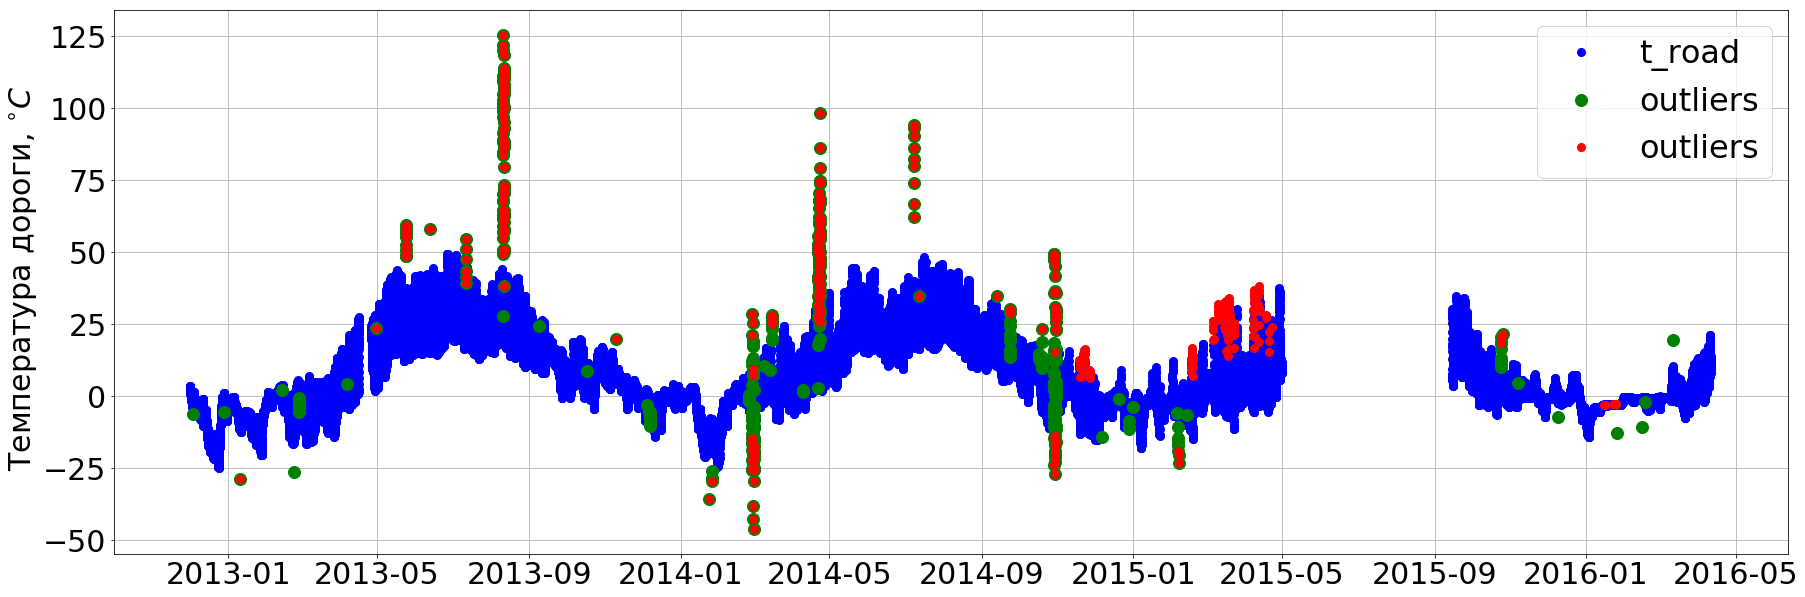

In [83]:
import matplotlib.pyplot as plt

#st_id = [114, 117, 119, 442, 504, 511, 1838, 1896]
#303, 307!!, 393!!, 503, 516
#test_station_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]
z = copy(df_test[df_test['station_id']==615].set_index('date_time_utc'))

start = pd.Timestamp(2012, 12, 1)
end = pd.Timestamp(2017, 2, 1)

to_plot = z[(z.index<=end) & (z.index>=start)]

plt.figure(figsize=(30, 10))

for elem in [True, False]:
    cond_predict = (to_plot['label_predict'] == 0) == elem
    cond_true = (to_plot['label_true'] == 0) == elem
    
    if elem:
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_t_road'], 'b',
                      linestyle='none', marker='o', markersize=8, label='t_road')
    else:
        
        plt.plot_date(to_plot[cond_true].index, to_plot[cond_true]['target_t_road'], 'g.',
                              linestyle='none', marker='o', label='outliers', markersize=12)
        
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_t_road'], 'r.',
                              linestyle='none', marker='o', label='outliers', markersize=8)

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' Температура дороги, $^{\circ}C$', fontsize=30)

plt.tick_params(labelsize=30)
plt.show()

In [20]:
z = df_test[['label_true', 'label_predict', 'decision_function']]
z.corr()

KeyError: "['label_predict' 'decision_function'] not in index"